<a href="https://colab.research.google.com/github/khushbooG9/Pointer-Networks-Using-Fast-Weights/blob/master/code%20-%20colab/boundary_PtrLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from __future__ import print_function
import random
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
tf.enable_eager_execution()


Hidden units = blend units while invoking PtrNetLSTM

In [0]:
class PtrNetLSTM(tf.keras.Model):
  def __init__(self, maxlen, batchsize, numblendunits, hiddensize=512): #J- input length, B-batch size, H-hidden units for lstm, D-blend units respectively
    super(PtrNetLSTM, self).__init__()
    self.maxlen = maxlen
    self.batchsize = batchsize
    self.hiddensize = hiddensize
    self.blendunits = numblendunits
    self.targetsize = 2 # (start,end) size 2 I
    self.input_dim = 1 # ignored, S-size of each vector
    self.generationsym = 20.0 #Used as starting value
    self.init = tf.random_normal_initializer(0.0, 0.5)
    self.encoder = tf.contrib.rnn.LSTMCell(hiddensize, initializer = self.init, dtype=tf.float32)
    self.decoder = tf.contrib.rnn.LSTMCell(hiddensize, initializer = self.init, dtype=tf.float32)
    self.W_e = tf.Variable(tf.random_uniform([self.input_dim, hiddensize], 0.0, 0.5), dtype=tf.float32)
    self.B_e = tf.Variable(tf.random_uniform([batchsize, hiddensize], 0.0, 0.5), dtype=tf.float32)
    #For mapping the raw input to LSTM dimensions
    self.W_d_in = tf.Variable(tf.random_uniform([self.input_dim, hiddensize], 0.0, 0.5), dtype=tf.float32)
    self.B_d_in = tf.Variable(tf.random_uniform([batchsize, hiddensize], 0.0, 0.5), dtype=tf.float32)
    self.W1 = tf.Variable(tf.random_uniform([ hiddensize, numblendunits], -0.08, 0.08), dtype=tf.float32)
    self.W2 = tf.Variable(tf.random_uniform([hiddensize, numblendunits], -0.08, 0.08), dtype=tf.float32)
    self.B_ptr = tf.Variable(tf.random_uniform([batchsize, numblendunits], 0.0, 0.5), dtype=tf.float32)
    self.V = tf.Variable(tf.random_uniform([numblendunits, 1], 0.0, 0.5), dtype=tf.float32) #Dx1
    
    
  def call(self, X):
    #Encoder function
    e_state = self.encoder.zero_state(self.batchsize, tf.float32) #BxH 0 is starting state for RNN
    e_states = []
    for i in range(self.maxlen):
      X_ = tf.cast(X[:, i:i+1], tf.float32) #BxS , step throuh input one at a time
      #Mapping raw input to LSTM dimensions
      #print(tf.matmul(X_, self.W_e).shape, self.B_e.shape)
      cell_input = tf.nn.elu(tf.matmul(X_, self.W_e) + self.B_e)  #BxH
      Y, e_state = self.encoder(cell_input, e_state) # Has c as BxH, h as BxH
      e_states.append(e_state) # no. of c and h are J in the list
      
      
    #Decoder function
    #Different special symbol, should not be from actual data
    startsymbol = tf.constant(self.generationsym, shape=(self.batchsize, self.input_dim), dtype = tf.float32) #BxS
    #First decoder state is last encoder state
    d_state = e_states[-1]
    ptr_Ys = []
    ptr_Y_dists = []
    X_ = startsymbol #BxS
    #print(X_)
    for i in range(self.targetsize):
      cell_input = tf.nn.elu(tf.matmul(tf.cast(X_,  tf.float32), self.W_d_in)+ self.B_d_in)
      Y, d_state = self.decoder(cell_input, d_state)  #Y = BxH d_state.c = BXH
      index_predists = []
      #Loop over each input to get softmax distribution
      d_part = tf.matmul(d_state.c, self.W2)  #BxD
      e_parts = []
      for index in range(self.maxlen):
        #Use the .c values not.h of each state
        #J's of Bx1, flattening to  JxB
        e_part = tf.matmul(e_states[index].c , self.W1)  #BxD
        rawblend = tf.nn.elu(e_part + d_part + self.B_ptr) #BxD
        scaled_blend = tf.matmul(rawblend, self.V) #Bx1
        index_predist = tf.reshape(scaled_blend, (self.batchsize,))
        e_parts.append(e_part)
        index_predists.append(index_predist)
        
      idx_predist = tf.transpose(tf.stack(index_predists))  #BxJ
      idx_dist = tf.nn.softmax(idx_predist, dim=1) #BxJ
      ptr_Y_dists.append(idx_dist)
      idx = tf.argmax(idx_dist, 1) #over last dimension, reduce rank #B
      
      #Pull out the input from index
      emb = tf.nn.embedding_lookup(tf.transpose(X), idx) #BxB
      ptr_Y_raw = tf.diag_part(emb) #B
      
      ptr_Y = tf.reshape(ptr_Y_raw, (self.batchsize, self.input_dim)) #BxS
      ptr_Ys.append(ptr_Y)
      X_ = ptr_Y #output goes back as input to decoder
    
    idx_distributions = tf.stack(ptr_Y_dists) #IxBxJ 
    return idx_distributions

Functions to generate the data sets . This generate low-high-low sequences where low is range [0,5] and high is range [6,10] integers. You can change the values to play around the code. 

In [0]:
def single_seq(length = 30, minlen = 5, maxlen=10):
  left = [(random.randint(1, 5)) for x in range(random.randint(minlen, maxlen))]
  mid = [(random.randint(6, 10)) for x in range(random.randint(minlen, maxlen))]
  right = [random.randint(1, 5) for x in range(random.randint(minlen, maxlen))]
  seq = left + mid + right
  seq = seq + ([0] * (length - len(seq)))
  #return index positions of the start and end of the middle sequence
  return (seq, len(left), len(left) + len(mid)-1)

def onehot(len, idx):
  oh = np.zeros([len])
  oh[idx] = 1
  return oh

def set_of_seq(n, l, minl, maxl):
  data = []
  starts = []
  ends = []
  datadict = {}
  for i in range(n):
    seq, ind_start, ind_end = single_seq(l, minl, maxl)#J, J,J
    data.append(seq)
    starts.append(onehot(len(seq),ind_start))
    ends.append(onehot(len(seq),ind_end))
  datadict[0] = np.stack(data) #BxJ
  datadict[1] = np.stack([np.stack(starts), np.stack(ends)]) 
  return datadict


Getting the training, validation and testing set ready. 

**For 3rd experiment, min and max length for training is 5 and 10, while for validation and testing it's 11 and 20.** This will actually determine the generalization ability of the network as it won't see any example of high values subsequence with length more than 10. But while testing it will predict the boundary indexes of the high value subsequence with length from 11 to 20.

**Make sure to keep maxlen =3*max high value subsequence length** 

In [0]:
maxlen = 60
samples = 1000
train = set_of_seq(samples, maxlen, 5, 10)
valid = set_of_seq(samples, maxlen, 11, 20)
test = set_of_seq(samples, maxlen, 11, 20)


Please make sure to keep the hidden and blend  equal.  Setting up the optimizer and intitalizing the PtrNetLSTM module 

In [91]:
optimizer = tf.train.AdamOptimizer(0.001)
batch= 100
hidden = blend = 256
pn = PtrNetLSTM(maxlen, batch, blend, hidden)

**Make sure to switch to GPU mode for the training**   Go to Runtime tab. Select change runtime to Python 3 and Accelator as GPU.

In [92]:
trainloss = []
trainbatchloss = []
validloss = []
validbatchloss = []
numepochs = 600
with tf.device("/gpu:0"):
  #l = 0
  for epoch in range(numepochs):
    print("Epoch number :", epoch)
    for i in range(0, samples, batch):
      l = 0
      vl = 0
      x = train[0][i:i+batch, :]
      y = train[1][:,i:i+batch,:]
      with tf.GradientTape() as tape:
        pred = pn(x)
        #print(y.shape, pred.shape)
        l += tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))
        trainloss.append(l)
      var = pn.variables
      grads = tape.gradient(l, var)
      optimizer.apply_gradients(zip(grads, var), global_step=tf.train.get_or_create_global_step())
      vx = valid[0][i:i+batch, :]
      vy = valid[1][:,i:i+batch,:]
      vpred = pn(vx)
      vl += tf.sqrt(tf.reduce_mean(tf.pow(vpred-vy, 2.0)))
      validloss.append(vl)
      if i==500:
        print("Validation set loss at batch : "+ str(i)+" is "+str(vl.numpy()))
    bl = (l/batch)
    trainbatchloss.append(bl)
    vbl = (vl/batch)
    validbatchloss.append(vbl)
    print("Epoch {:03d}/{:03d} completed \t - \ total average batch loss: {:.9f}".format((epoch+1), numepochs, tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))))
  print("Final loss for training  set: {:.9f}".format(tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))))
      
    
  

Epoch number : 0
Validation set loss at batch : 500 is 0.16600582
Epoch 001/600 completed 	 - \ total batch loss: 0.154986113
Epoch number : 1
Validation set loss at batch : 500 is 0.16177353
Epoch 002/600 completed 	 - \ total batch loss: 0.148416728
Epoch number : 2
Validation set loss at batch : 500 is 0.15722269
Epoch 003/600 completed 	 - \ total batch loss: 0.144889772
Epoch number : 3
Validation set loss at batch : 500 is 0.15593928
Epoch 004/600 completed 	 - \ total batch loss: 0.143657967
Epoch number : 4
Validation set loss at batch : 500 is 0.15149106
Epoch 005/600 completed 	 - \ total batch loss: 0.141470566
Epoch number : 5
Validation set loss at batch : 500 is 0.14817037
Epoch 006/600 completed 	 - \ total batch loss: 0.139061347
Epoch number : 6
Validation set loss at batch : 500 is 0.14567977
Epoch 007/600 completed 	 - \ total batch loss: 0.138034746
Epoch number : 7
Validation set loss at batch : 500 is 0.14326254
Epoch 008/600 completed 	 - \ total batch loss: 0.13

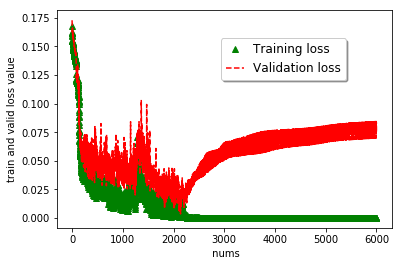

Text(0.5, 0, 'batch nums')

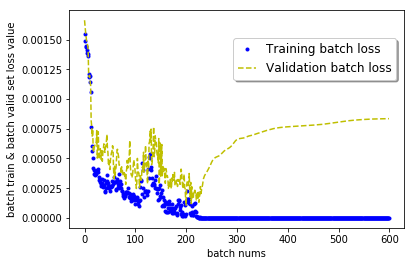

In [93]:
plt.plot(trainloss,'g^', validloss, 'r--')
plt.legend(('Training loss', 'Validation loss'),
           shadow=True, loc=(0.49, 0.68), handlelength=1.5, fontsize=12)

plt.ylabel('train and valid loss value')
plt.xlabel(' nums')

plt.show()

plt.plot(trainbatchloss, 'b.', validbatchloss, 'y--')
plt.legend(('Training batch loss', 'Validation batch loss'),
           shadow=True, loc=(0.49, 0.68), handlelength=1.5, fontsize=12)

plt.ylabel('batch train & batch valid set loss value')
plt.xlabel('batch nums')



Testing the trained model for accuracy

In [94]:

count = 0
for i in range(0, samples,batch):
  l = 0
  x = test[0][i:i+batch, :]
  y = test[1][:,i:i+batch,:]
  testpred = pn(x)
  l+= tf.sqrt(tf.reduce_mean(tf.pow(testpred-y, 2.0)))
  for k in range(batch):
    first = np.argmax(testpred[0,k,:])
    second = np.argmax(testpred[1,k,:])
    print("For the sequence :", test[0][k+i,:])
    print("Predicted Indexes: (" + str(first) + "," + str(second)+") ")
    print("Actual boundary indexes :",np.where(test[1][0,k+i,:])[0], np.where(test[1][1,k+i,:])[0])
    if np.where(test[1][0,k+i,:])[0]==first and np.where(test[1][1,k+i,:])[0] == second:
      count+=1
      
print("Correct prediction counts:" , count)
print("Prediction accuracy :" , count/samples)




For the sequence : [ 5  1  2  5  2  5  2  5  3  2  5  2  5  2  4  8  7  9  6  8  9  9  7 10
  9  7  9  6 10  7  7  9  7  7  3  3  3  3  1  5  2  1  4  2  4  5  2  3
  3  3  5  5  1  2  0  0  0  0  0  0]
Predicted Indexes: (33,33) 
Actual boundary indexes : [15] [33]
For the sequence : [ 3  2  3  5  4  1  4  1  5  5  4  3  3  5  1  9  6  6  6  6 10 10  8  9
  9  9  7  7  5  3  4  4  5  4  5  2  2  4  5  2  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
Predicted Indexes: (15,27) 
Actual boundary indexes : [15] [27]
For the sequence : [ 2  5  4  4  3  2  3  3  2  5  4  5  2  4  2  2  4  4  4  5  8 10  9  9
  8  9  7  7  8 10  6 10  6  8  9  8  2  1  2  3  1  1  5  2  5  5  2  5
  3  0  0  0  0  0  0  0  0  0  0  0]
Predicted Indexes: (35,35) 
Actual boundary indexes : [20] [35]
For the sequence : [ 5  4  5  4  5  2  5  1  3  2  1  5  3  3  5  4  2  3  5  6 10  8  9  8
  6 10  9  6  6 10  8  7  9  5  3  3  4  2  2  5  2  3  2  4  5  4  0  0
  0  0  0  0  0  0  0  0  0  0  0 